In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Effective magnetic field plots (Morales-Durán et al.)

Goal: follow the computations in the paper and, using the same symbols, plot the relevant parameters of the bilayer Hamiltonian and the effective magnetic field obtained from it.

Paper https://arxiv.org/pdf/2308.03143.pdf

In [28]:
class twistedTMB:

    def __init__(self, modelParameters_, N, xMax):
        
        self.Vm, self.phi, self.w, self.aM = modelParameters_
        self.N = N
        self.xMax = abs(xMax)

        self.k_theta = (4 * np.pi * self.aM) / np.sqrt(3)
        self.G1, self.G2, self.G3, self.G4, self.G5, self.G6 = [self.k_theta * np.array([np.cos(np.pi * i/3), np.sin(np.pi * i/3)]) for i in range(1,7)]
        self.q1 = self.k_theta * np.array([0, -1 / np.sqrt(3)])
        self.q2 = self.G2 + self.q1
        self.q3 = self.G3 + self.q1

        self.xArray = self.aM * np.linspace(-self.xMax, self.xMax, self.N, endpoint=True)
        self.yArray = self.aM * np.linspace(-self.xMax, self.xMax, self.N, endpoint=True)

    # interlayer potentials
    
    def Del_b(self):
        Del_b = np.zeros((self.N,self.N))
        for i in range(self.N):
                for j in range(self.N):
                    r = np.array([self.xArray[i], self.yArray[j]])
                    Del_b[i,j] = 2 * self.Vm * (np.cos(np.vdot(self.G1, r) + self.phi) +
                                                np.cos(np.vdot(self.G3, r) + self.phi) +
                                                np.cos(np.vdot(self.G5, r) + self.phi))
        return Del_b
    
    def plot(self, field):
        fig, ax = plt.subplots(layout='constrained')

        ax.set_aspect('equal')
        ax.set_title('$B_{eff}$')
        ax.set_xlabel('$x/a_M$')
        ax.set_ylabel('$y/a_M$')
        contours = ax.contourf(self.xArray, self.yArray, field, levels=9, cmap='Spectral_r')
        cbar = fig.colorbar(contours)
        plt.show()




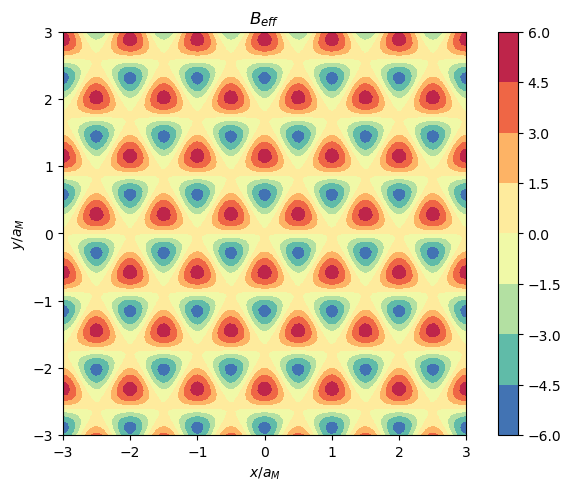

In [29]:
A = twistedTMB([1, 89.6 * np.pi / 180, 1, 1], 100, 3)
Del_b = A.Del_b()
A.plot(Del_b)
